
<span style="font-size:24px; color:white">Firslty select the GPU and model, in this setup I'm using NVIDIA L40S and XLM-Roberta-Base</span>


In [ ]:
import os
from transformers import AutoModel
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "0"  

device = torch.device("cuda:0")
model = AutoModel.from_pretrained("xlm-roberta-base")
model = model.to(device)
print(
    "GPU Name:",
    torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU",
)

e:\Research\cuda_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import os
import re
from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoTokenizer

<span style="font-size:20px; color:white">In this step we will Pre Prcoess the data, final output would be a Object with 2 features also we will give the labels a unique ID for futher evaluation <br>
-->"tokens"
<br>
-->"ner_tags"
</span>

In [ ]:
label2id = {
    "O": 0,
    "B-per": 1,
    "I-per": 2,
    "B-org": 3,
    "I-org": 4,
    "B-loc": 5,
    "I-loc": 6,
}
dataset = load_dataset(
    "text",
    data_files={
        "train": r"Datasets/hindi/naamapadam-train_mapped.txt",
        "test": r"E:\Research\Datasets\hindi\naamapadam-test_mapped.txt",
        "validation": r"E:\Research\Datasets\hindi\naamapadam-validation_mapped.txt",
    },
)


def parse_token_tag_pairs(split):
    lines = [line["text"].strip() for line in dataset[split] if line["text"].strip()]
    samples = []

    for i in range(0, len(lines), 2):
        if not lines[i].startswith("TOKENS:") or not lines[i + 1].startswith("TAGS:"):
            continue  # Skip invalid

        tokens = lines[i].replace("TOKENS:", "").strip().split()
        tags = lines[i + 1].replace("TAGS:", "").strip().split()

        if len(tokens) != len(tags):
            continue

        samples.append(
            {"tokens": tokens, "ner_tags": [label2id.get(tag, 0) for tag in tags]}
        )

    return samples

hf_dataset = DatasetDict(
    {
        "train": Dataset.from_list(parse_token_tag_pairs("train")),
        "validation": Dataset.from_list(parse_token_tag_pairs("validation")),
        "test": Dataset.from_list(parse_token_tag_pairs("test")),
    }
)

In [ ]:

from collections import Counter

tag_counter = Counter()

for split in ["train", "validation", "test"]:
    for sample in hf_dataset[split]:
        tag_counter.update(sample["ner_tags"])

print("Tag distribution across dataset:")
for tag, count in tag_counter.items():
    print(f"{tag}: {count}")

Tag distribution across dataset:
0: 17285544
1: 732981
2: 681021
3: 656228
4: 789443
5: 698064
6: 197712


<span style="font-size:20px; color:white">Tokenization process, every token in from the dataset get an inout_id, label and attention mask </span>


In [ ]:
# Tokenization function
model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        padding="max_length",
        truncation=True,
        max_length=128,
    )

    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example["ner_tags"][word_idx])
        else:
            labels.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


tokenized_dataset = hf_dataset.map(tokenize_and_align_labels, batched=False)

Map: 100%|██████████| 867/867 [00:00<00:00, 2513.05 examples/s]


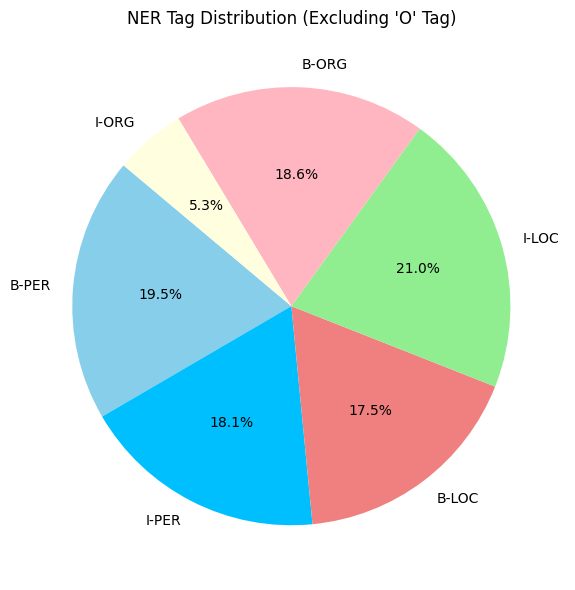

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

tag_counter = Counter()

for split in ["train", "test", "validation"]:
    for sample in tokenized_dataset[split]:
        tag_counter.update(sample["ner_tags"])
id2label = {
    0: "O",
    1: "B-PER",
    2: "I-PER",
    3: "B-LOC",
    4: "I-LOC",
    5: "B-ORG",
    6: "I-ORG",
}

# Filter out the 'O' tag (assuming its index is 0)
filtered_counter = {i: c for i, c in tag_counter.items() if id2label[i] != "O"}

# Prepare data
labels = [id2label[i] for i in filtered_counter]
sizes = list(filtered_counter.values())
colors = ["skyblue", "deepskyblue", "lightcoral", "lightgreen", "lightpink", "lightyellow"]

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)

# Chart styling
plt.title("NER Tag Distribution (Excluding 'O' Tag)")
plt.tight_layout()
plt.show()

<span style="font-size:20px; color:white">The above preprocessing may differ from the original code as the dataset used in the code was XCOPA and here we are using NER data.
</span>

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label2id),  
    id2label={v: k for k, v in label2id.items()},
    label2id=label2id,
)

In [ ]:
# Remove non-numeric columns from tokenized_dataset
columns_to_remove = ["tokens", "ner_tags", "raw_tags"]  # keep only model input columns
tokenized_dataset = tokenized_dataset.remove_columns(
    [col for col in columns_to_remove if col in tokenized_dataset["train"].column_names]
)

print(tokenized_dataset["train"])  # Should only show input_ids, attention_mask, labels

<span style="font-size:20px; color:white">Now we will call a pretrained adapter model which would get tranied by the NER dataset, this will perform as Task Adapter. Since we are using Hindi Dataset we will load a Hindi Language adapter. After that we will add the Task Adapter named -- "Hindi_Task_adapter", after this we will call a function "train_adapter" which will frezze the model.</span>  

In [ ]:
from adapters import AutoAdapterModel
from transformers import AutoConfig

config = AutoConfig.from_pretrained(
    "xlm-roberta-base",
)
model = AutoAdapterModel.from_pretrained(
    "xlm-roberta-base",
    config=config,
)

In [ ]:
# Loading Language Adapter
from adapters import AdapterConfig

config = AdapterConfig.load("pfeiffer", non_linearity="relu", reduction_factor=2)
model.load_adapter("hi/wiki@ukp", config=config)

In [ ]:
task_adapter_config = AdapterConfig.load("pfeiffer", reduction_factor=16)
model.add_adapter(
    "hindi_task_adapter", config=task_adapter_config, overwrite_ok=True
)
model.add_tagging_head(
    "hindi_task_adapter", num_labels=len(label2id), overwrite_ok=True
)

In [ ]:
model.train_adapter("hindi_task_adapter")

<span style="font-size:20px; color:white">This Stack setup will be then be passed for further traning</span>

In [ ]:
from adapters.composition import Stack

model.active_adapters = Stack("hi", "hindi_task_adapter")

In [ ]:
from adapters import AdapterTrainer
from transformers import TrainingArguments


training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=2000,
    output_dir="./hindi_task_adapter",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
    no_cuda=True,  # Disable CUDA for debugging purposes
    fp16=True,  # Enable mixed precision training

    
)


trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"].,  # Use a subset of 1000 samples for training
    eval_dataset=tokenized_dataset["validation"],
)

In [ ]:
trainer.train()

In [ ]:
model.save_adapter("./hindi_task_adapter", "hindi_task_adapter")

In [ ]:
# Define your label mapping
label2id = {
    "O": 0,  
    "B-per": 1,
    "I-per": 2,
    "B-org": 3,
    "I-org": 4,
    "B-loc": 5,
    "I-loc": 6,
}
dataset = load_dataset(
    "text",
    data_files={
        "train": r"Datasets/bhojpuri/naamapadam-train_mapped.txt",
        "test": r"Datasets/bhojpuri/naamapadam-test_mapped.txt",
    },
)



def parse_token_tag_pairs(split):
    lines = [line["text"].strip() for line in dataset[split] if line["text"].strip()]
    samples = []

    for i in range(0, len(lines), 2):
        if not lines[i].startswith("TOKENS:") or not lines[i + 1].startswith("TAGS:"):
            continue  

        tokens = lines[i].replace("TOKENS:", "").strip().split()
        tags = lines[i + 1].replace("TAGS:", "").strip().split()

        if len(tokens) != len(tags):
            continue

        samples.append(
            {"tokens": tokens, "ner_tags": [label2id.get(tag, 0) for tag in tags]}
        )

    return samples



dataset_bj = DatasetDict(
    {
        "train": Dataset.from_list(parse_token_tag_pairs("train")),
        "test": Dataset.from_list(parse_token_tag_pairs("test")),
    }
)


In [ ]:

model_checkpoint = "xlm-roberta-base"  
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)  


def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        padding="max_length",
        truncation=True,
        max_length=128,
    )

    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)  
        elif word_idx != previous_word_idx:
            labels.append(example["ner_tags"][word_idx])  
        else:
            labels.append(-100)  
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
dataset_bj = dataset_bj.map(tokenize_and_align_labels, batched=False)

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label2id),  
    id2label={v: k for k, v in label2id.items()},
    label2id=label2id,
)

In [ ]:
columns_to_remove = ["tokens", "ner_tags"]  
dataset_bj = dataset_bj.remove_columns(
    [col for col in columns_to_remove if col in dataset_bj["train"].column_names]
)

# Should only show input_ids, attention_mask, labels

<span style="font-size:20px; color:white">After preprocessing the target language we will load Target Language Adapter which in this case is "indic_bhojpuri_lang_adapter"
then it would satcked with the Source language Task Adapter which would "Hindi_Task_Adapter", we will also load a Adapter Model which will used for Inference.</span>

In [ ]:
from adapters import AutoAdapterModel
from adapters.composition import Stack

# Load base adapter model
model = AutoAdapterModel.from_pretrained("xlm-roberta-base")
model.load_adapter("indic_bhojpuri_lang_adapter")
model.load_adapter("hindi_task_adapter")

# Activate adapters
model.active_adapters = Stack("indic_bhojpuri_lang_adapter", "hindi_task_adapter")

In [ ]:
# Global store for confusion matrix
all_true_labels = []
all_pred_labels = []

from sklearn.metrics import precision_recall_fscore_support, accuracy_score


def compute_metrics(p):
    import numpy as np

    global all_true_labels, all_pred_labels

    preds = np.argmax(p.predictions, axis=-1)
    labels = p.label_ids

    true_labels = []
    pred_labels = []

    for pred_seq, label_seq in zip(preds, labels):
        for pred_idx, label_idx in zip(pred_seq, label_seq):
            if label_idx == -100:
                continue  # Skip padding
            true_tag = id2label[int(label_idx)]
            pred_tag = id2label[int(pred_idx)]
            if true_tag != "O":  # Ignore 'O' tags
                true_labels.append(true_tag)
                pred_labels.append(pred_tag)

    # Store for confusion matrix
    all_true_labels = true_labels
    all_pred_labels = pred_labels

    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average="macro", zero_division=0
    )
    acc = accuracy_score(true_labels, pred_labels)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": round(acc, 4),
    }

In [ ]:
eval_trainer = AdapterTrainer(
    model=model,
    args=TrainingArguments(
        output_dir="./eval_output",
        remove_unused_columns=False,
    ),
    eval_dataset=dataset_bj["test"],
    compute_metrics=compute_metrics,
)
eval_trainer.evaluate()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(true_labels, pred_labels, labels):
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("NER Confusion Matrix (excluding 'O')")
    plt.show()


# Call this after evaluation
unique_labels = sorted(set(all_true_labels + all_pred_labels))
plot_confusion_matrix(all_true_labels, all_pred_labels, labels=unique_labels)